In [1]:
import os
import shutil
import  joblib
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import tqdm


In [2]:
DATA_ROOT = Path("../data/")
TRAIN_AUDIO_ROOT = Path("../data/train")
TEST_AUDIO_ROOT = Path("../data/test")

In [3]:
df_train = pd.DataFrame({
    "recording_id": [path.stem for path in Path(TRAIN_AUDIO_ROOT).glob("*.flac")],
})

df_test = pd.DataFrame({
    "recording_id": [path.stem for path in Path(TEST_AUDIO_ROOT).glob("*.flac")],
})


In [4]:
len(df_train)

4727

In [5]:
class params:
    """
    Parameters used for the audio data
    """
    sr = 3200
    # Melspectrogram
    n_mels = 128
    fmin = 20
    fmax = sr // 2  # Shannon theorem

In [6]:
def load_audio(record, sr=16000, root=""):
    y, _ = lb.load(
        root.joinpath(record).with_suffix(".flac").as_posix(),
        sr=sr, 
    )
    return y

In [7]:
def compute_melspec(y, params):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = lb.feature.melspectrogram(
        y, sr=params.sr, n_mels=params.n_mels, 
        fmin=params.fmin, fmax=params.fmax,
    )
    melspec = lb.power_to_db(melspec).astype(np.float32)
    return melspec

In [10]:
y = load_audio(df_test["recording_id"][0], params.sr, TEST_AUDIO_ROOT)

In [11]:
melspec = compute_melspec(y, params)

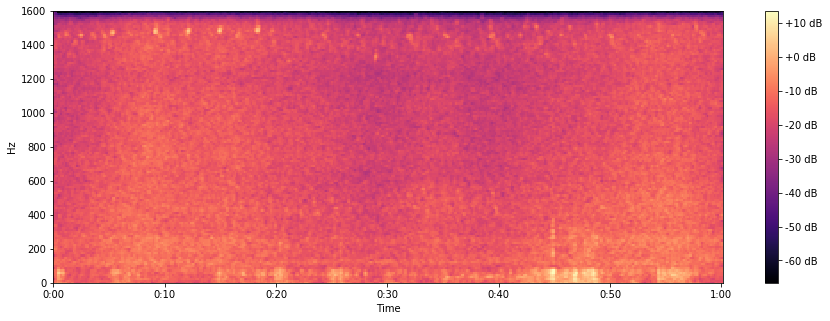

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
img = librosa.display.specshow(
    melspec[:, :512], 
    sr=params.sr,
    x_axis='time', 
    y_axis='linear', 
    ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.show()

In [19]:
melspec.shape, melspec.min(), melspec.max()

((128, 376), -66.56544, 13.434561)

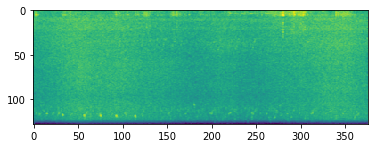

In [18]:
plt.imshow(melspec)

### Main

Load all audio files, generate their spectograms, save them as npy files

In [8]:
def load_and_save_train(record):
    y = load_audio(record, params.sr, TRAIN_AUDIO_ROOT)
    melspec = compute_melspec(y, params)

    np.save(OUT_TRAIN + record + ".npy", melspec)

In [10]:
OUT_TRAIN = '../data/train_npy/'
# os.mkdir(OUT_TRAIN)

In [11]:
_ = joblib.Parallel(n_jobs=10)(
    joblib.delayed(load_and_save_train)(record) for record in tqdm(df_train['recording_id'].values)
)

In [ ]:
# shutil.make_archive(OUT_TRAIN, 'zip', OUT_TRAIN)
# shutil.rmtree(OUT_TRAIN)

In [21]:
def load_and_save_test(record):
    y = load_audio(record, params.sr, TEST_AUDIO_ROOT)
    melspec = compute_melspec(y, params)

    np.save(OUT_TEST + record + ".npy", melspec)

In [22]:
OUT_TEST = 'test/'
os.mkdir(OUT_TEST)


In [23]:
_ = joblib.Parallel(n_jobs=8)(
    joblib.delayed(load_and_save_test)(record) for record in tqdm(df_test['recording_id'].values)
)

### mean and std

In [17]:
means = []
stds = []
for f in Path('../data/train_npy/').glob('*.npy'):
    img = np.load(f)
    means.append(img.mean())
    stds.append(img.std())

In [19]:
np.mean(means), np.mean(stds)

(-23.061497, 7.350505)

In [14]:
img.shape, img.mean(), img.mean(), img.max()

((128, 376), -20.06131, -20.06131, 16.300446)

### 